In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from sklearn.manifold import TSNE
import numpy as np

## Plotting finction

In [ ]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

## Input

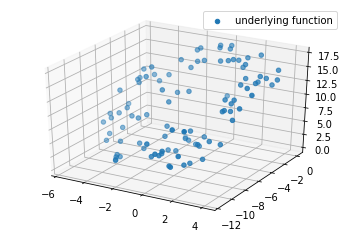

In [ ]:
bias_true = tf.constant([1,-1],dtype=tf.dtypes.float32)
x = tf.random.uniform(shape=[100,3], minval=-1., maxval=0.,dtype=tf.dtypes.float32)
weights_1 = tf.transpose(tf.constant([[1, 1,0],[1,0,1]],dtype=tf.dtypes.float32))
weights_2 = tf.transpose(tf.constant([[0,0,1],[0,1,0]],dtype=tf.dtypes.float32))
y_true = tf.matmul(x , weights_1) +  tf.matmul(x , weights_2) + bias_true
X_embedded = TSNE(n_components=2).fit_transform(x)
y_embedded = TSNE(n_components=1).fit_transform(y_true)

plot_3d(X_embedded, y_embedded)


## Loss function and Linear Layer

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return tf.math.reduce_mean((y_pred - y_true) ** 2)

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient

class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = tf.random.uniform(shape=[input_dim,num_hidden], minval=-1., maxval=0.,dtype=tf.dtypes.float32) * tf.sqrt(2. / input_dim)
    self.bias = tf.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = tf.square(x)@ self.weights + x @ self.weights + self.bias
    return output

  # dy/dx = 2*x*weights_true + weights_true
  # dy/dw = x2 + x
  # dy/db = 1
  def backward(self, gradient):
    self.weights_gradient = tf.transpose((tf.square(self.x) + self.x)) @ gradient
    self.bias_gradient = tf.math.reduce_sum(gradient)
    self.x_gradient = gradient @ tf.transpose(self.weights)

    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

## Relu Layer

In [ ]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = tf.maximum(self.input_, 0)
        return self.output
    
    def backward(input, output_gradient): 
      self.input_gradient=tf.cast(tf.math.greater(input, 0),dtype='float32')* output_gradient
      return self.input_gradient

## Defining model

In [ ]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, 6)
    self.relu = Relu()
    self.linear2 = Linear(6, 4)
    self.relu2 = Relu()
    self.linear3 = Linear(4, 2)

  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):

    linear3_gradient = self.linear3.backward(output_gradient)
    relu_gradient = self.relu2.backward(linear3_gradient)

    linear2_gradient = self.linear2.backward(relu_gradient)
    relu2_gradient = self.relu.backward(linear2_gradient)

    linear1_gradient = self.linear1.backward(relu2_gradient)
    return linear3_gradient

  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(3, 1)
y_pred = model(x)
#print(y_pred.shape)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
#print(loss_value)
model.backward(loss_gradient)

<tf.Tensor: shape=(100, 4), dtype=float32, numpy=
array([[-0.01326767, -0.03584997, -0.0300845 , -0.01223716],
       [-0.01973695, -0.04849612, -0.04080809, -0.0162529 ],
       [-0.02341298, -0.05568202, -0.04690154, -0.01853476],
       [-0.01062105, -0.03067634, -0.0256974 , -0.01059429],
       [-0.03150029, -0.07149109, -0.0603072 , -0.02355488],
       [-0.01276112, -0.03485975, -0.02924482, -0.01192272],
       [-0.01020369, -0.02986049, -0.02500558, -0.01033522],
       [-0.01118512, -0.031779  , -0.02663243, -0.01094444],
       [-0.01257742, -0.03450065, -0.02894031, -0.01180869],
       [-0.01326455, -0.03584386, -0.03007932, -0.01223522],
       [-0.01131747, -0.0320377 , -0.0268518 , -0.01102659],
       [-0.00607764, -0.02179488, -0.01816617, -0.00777401],
       [-0.01220011, -0.0337631 , -0.02831489, -0.01157448],
       [-0.01859963, -0.04627287, -0.03892284, -0.01554692],
       [-0.02020333, -0.0494078 , -0.04158117, -0.0165424 ],
       [-0.01689836, -0.04294723, -

## Training

Epoch 0, loss 1.27915620803833
Epoch 1, loss 1.27915620803833
Epoch 2, loss 1.27915620803833
Epoch 3, loss 1.27915620803833
Epoch 4, loss 1.27915620803833
Epoch 5, loss 1.27915620803833
Epoch 6, loss 1.27915620803833
Epoch 7, loss 1.2791560888290405
Epoch 8, loss 1.27915620803833
Epoch 9, loss 1.27915620803833
Epoch 10, loss 1.27915620803833
Epoch 11, loss 1.27915620803833
Epoch 12, loss 1.27915620803833
Epoch 13, loss 1.27915620803833
Epoch 14, loss 1.27915620803833
Epoch 15, loss 1.27915620803833
Epoch 16, loss 1.27915620803833
Epoch 17, loss 1.27915620803833
Epoch 18, loss 1.27915620803833
Epoch 19, loss 1.27915620803833
Epoch 20, loss 1.27915620803833
Epoch 21, loss 1.27915620803833
Epoch 22, loss 1.27915620803833
Epoch 23, loss 1.27915620803833
Epoch 24, loss 1.27915620803833
Epoch 25, loss 1.27915620803833
Epoch 26, loss 1.27915620803833
Epoch 27, loss 1.27915620803833
Epoch 28, loss 1.27915620803833
Epoch 29, loss 1.27915620803833
Epoch 30, loss 1.2791560888290405
Epoch 31, loss

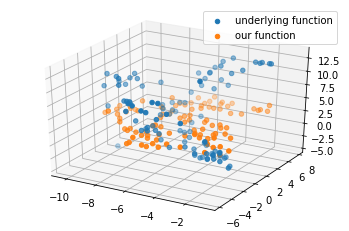

In [ ]:
num_epochs=70
lr=0.02

for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y_true)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)
y_pred= model(x)
y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred)
X_embedded = TSNE(n_components=2).fit_transform(x)
y_embedded = TSNE(n_components=1).fit_transform(y_true)
plot_3d(X_embedded, y_embedded,y_pred_embedded)